https://karthikkaranth.me/blog/implementing-seam-carving-with-python/

https://ben-tanen.com/projects/2020/10/08/seam-carving-pt1.html

In [1]:

"""
Usage: python carver.py <r/c> <scale> <image_in> <image_out>
Copyright 2018 Karthik Karanth, MIT License
"""

import sys

from tqdm import trange
import numpy as np
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt

def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map

def crop_c(img, scale_c):
    r, c, _ = img.shape
    new_c = np.int32(scale_c * c)

    for i in trange(c - new_c):
        img = carve_column(img)

    return img

def crop_r(img, scale_r):
    img = np.rot90(img, 1, (0, 1))
    img = crop_c(img, scale_r)
    img = np.rot90(img, 3, (0, 1))
    return img

def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)
    mask = np.ones((r, c), dtype=bool)

    j = np.argmin(M[-1])
    for i in reversed(range(r)):
        mask[i, j] = False
        j = backtrack[i, j]

    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((r, c - 1, 3))
    return img

def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int32)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index a -1
            if j == 0:
                idx = np.argmin(M[i-1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i-1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack



C:\Users\mathp\AppData\Local\Temp\ipykernel_15520\4151341211.py:11: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


C:\Users\mathp\AppData\Local\Temp\ipykernel_15520\1609009476.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(in_filename)
100%|██████████| 138/138 [00:19<00:00,  7.13it/s]


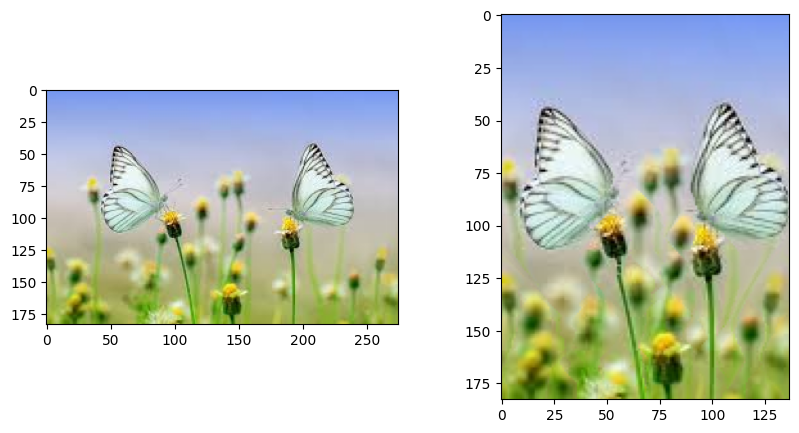

In [2]:
which_axis = 'c'
scale = 0.5
in_filename = 'two-butterfly.jpg'
# out_filename = sys.argv[4]
img = imread(in_filename)
if which_axis == 'r':
    out = crop_r(img, scale)
elif which_axis == 'c':
    out = crop_c(img, scale)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(out.astype(np.int16))

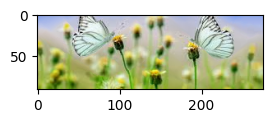

In [12]:
plt.subplot(1, 2, 2)
plt.imshow(out.astype(np.int16))

In [ ]:
def main():
    if len(sys.argv) != 5:
        print('usage: carver.py <r/c> <scale> <image_in> <image_out>', file=sys.stderr)
        sys.exit(1)

    which_axis = sys.argv[1]
    scale = float(sys.argv[2])
    in_filename = sys.argv[3]
    out_filename = sys.argv[4]

    img = imread(in_filename)

    if which_axis == 'r':
        out = crop_r(img, scale)
    elif which_axis == 'c':
        out = crop_c(img, scale)
    else:
        print('usage: carver.py <r/c> <scale> <image_in> <image_out>', file=sys.stderr)
        sys.exit(1)
    
    imwrite(out_filename, out)

if __name__ == '__main__':
    main()